## Equivalence Claim (Read First)

**Claim in this notebook:** Rank-1 EMPCA (`k=1`) and Optimal Filtering (OF) show strong empirical equivalence on **real K-alpha data** when preprocessing and PSD weighting are matched.

This notebook is a **real-data verification notebook**. It is not presented as a standalone formal proof for all conditions.


# Strict OF vs Rank-1 EMPCA (Real K-alpha Verification)

This notebook performs a strict real-data verification using matched OF/EMPCA settings.

## What is made strict here
- Use **linear `rfft` domain** (no `ti_rfft` phase transform).
- Use **OF-exact one-sided weights** from PSD (`w[0]=0`, interior `2/J`, Nyquist `1/J`).
- Disable EMPCA smoothing by running the solver loop directly (no Savitzky-Golay step).
- Phase-align EMPCA basis to template (global complex phase gauge fix).
- Verify direct GLS projection on template against `OptimumFilter.fit`.
- Compare OF and EMPCA with amplitude agreement and weighted residual-energy consistency.

Note: EMPCA basis/coefficient in frequency space are complex in general; amplitude comparisons use `Re(c)` after phase alignment, while residual tests use full complex `c`.


In [1]:
import sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.stats import linregress, ks_2samp

sys.path.append("../../")
from reusable.OptimumFilter import OptimumFilter
from reusable.empca_equivalence_utils import (
    baseline_correct,
    build_of_one_sided_weights,
    weighted_inner,
    weighted_cosine,
    phase_align_basis,
    project_gls,
    weighted_residual_energy,
    fit_empca_no_smoothing,
)

plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams["font.size"] = 12


In [2]:
def fit_rank1_empca_no_smoothing(X_f, w, n_iter=50, patience=8):
    eigvec, _, chi2s = fit_empca_no_smoothing(
        X_f,
        w,
        n_comp=1,
        n_iter=n_iter,
        patience=patience,
        mode="fast",
    )
    return eigvec[0], chi2s


In [4]:
# Paths and global parameters
TRACES_PATH = "../../reusable/k_alpha/k_alpha_traces.h5"
TEMPLATE_PATH = "../../reusable/k_alpha/template_K_alpha_tight.npy"
PSD_PATH = "/ceph/dwong/delight/noise_psd_xray.npy"

PRETRIGGER = 2000
N_ITER_REAL = 50
N_REAL_LIMIT = None  # set an int (e.g., 2000) to speed up on laptop

# Load template and PSD
s_template = np.load(TEMPLATE_PATH).astype(np.float64)
s_template = s_template - np.mean(s_template[:PRETRIGGER])

psd_arr = np.load(PSD_PATH)
if psd_arr.ndim == 2 and psd_arr.shape[0] == 2:
    J_psd = psd_arr[1]
else:
    J_psd = psd_arr
J_psd = J_psd.astype(np.float64)

T = s_template.shape[0]
w_of = build_of_one_sided_weights(J_psd, T)
S_f = np.fft.rfft(s_template)

print(f"Template length: {T}")
print(f"PSD bins: {J_psd.shape[0]}")
print(f"Nonzero weights: {(w_of > 0).sum()} / {w_of.size}")


Template length: 32768
PSD bins: 16385
Nonzero weights: 16384 / 16385


## Real K-alpha Verification

This section evaluates equivalence behavior directly on measured K-alpha traces.


In [5]:
with h5py.File(TRACES_PATH, "r") as f:
    X_real = f["traces"][:].astype(np.float64)

if N_REAL_LIMIT is not None:
    X_real = X_real[:N_REAL_LIMIT]

X_real = baseline_correct(X_real, pretrigger=PRETRIGGER)
X_real_f = np.fft.rfft(X_real, axis=1)

n_train_real = X_real.shape[0] // 2
X_real_train_f = X_real_f[:n_train_real]
X_real_test_f = X_real_f[n_train_real:]
X_real_test_t = X_real[n_train_real:]

print(f"Real traces used: {X_real.shape[0]} (train/test: {n_train_real}/{X_real.shape[0]-n_train_real})")


Real traces used: 4358 (train/test: 2179/2179)


Real: max |a_OF - a_template_GLS| = 5.534e-04
Real weighted cosine rho_w(U,S): 1.000000
Real regression: a_emp = 16005.405770 * a_of + 2362.616239
Real correlation r: 0.994201
Real origin-fit scale alpha0: 16005.632836
Real median relative error (origin-fit): 9.678e-05
Real residual KS statistic=0.0303, p=0.2703


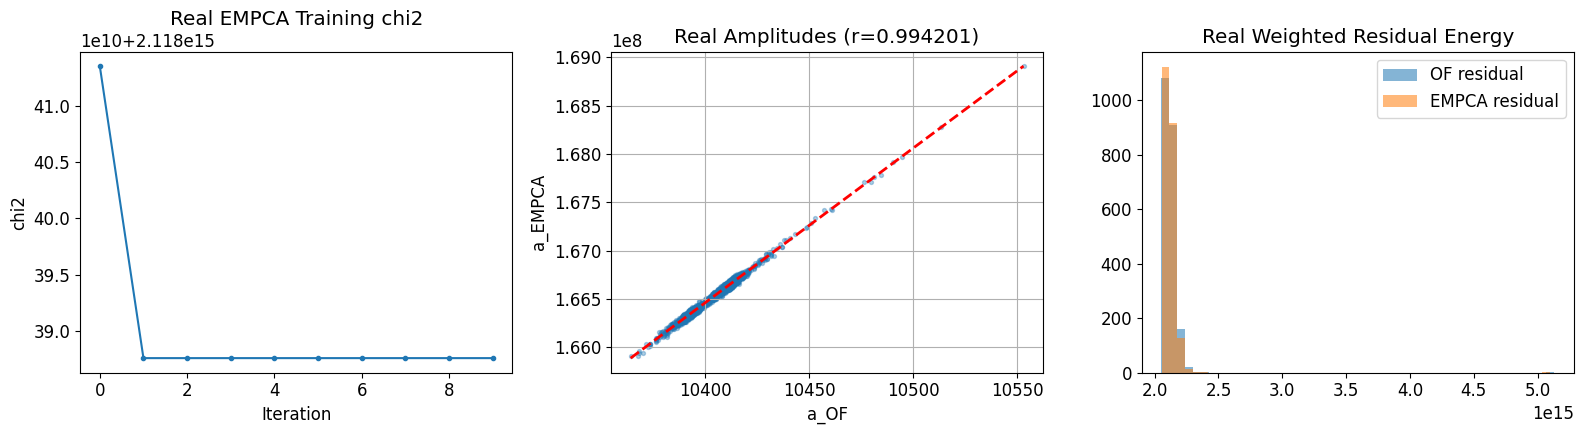

In [6]:
# OF and template-GLS agreement on real data (sanity check)
of_real = OptimumFilter(s_template, J_psd, sampling_frequency=1.0)
a_of_real = np.array([of_real.fit(x)[0] for x in X_real_test_t], dtype=np.float64)
a_tpl_real = project_gls(X_real_test_f, S_f, w_of)
max_abs_diff_real = np.max(np.abs(a_of_real - a_tpl_real))
print(f"Real: max |a_OF - a_template_GLS| = {max_abs_diff_real:.3e}")

# Strict EMPCA (no smoothing)
U_real, chi2_real = fit_rank1_empca_no_smoothing(X_real_train_f, w_of, n_iter=N_ITER_REAL, patience=8)
U_real = phase_align_basis(U_real, S_f, w_of)

rho_real = weighted_cosine(U_real, S_f, w_of)
a_emp_real_c = project_gls(X_real_test_f, U_real, w_of, return_complex=True)
a_emp_real = np.real(a_emp_real_c)

fit_real = linregress(a_of_real, a_emp_real)
alpha_real, beta_real, r_real = fit_real.slope, fit_real.intercept, fit_real.rvalue
alpha0_real = np.dot(a_of_real, a_emp_real) / np.dot(a_of_real, a_of_real)
med_rel_real = np.median(np.abs(a_emp_real - alpha0_real * a_of_real) / np.abs(alpha0_real * a_of_real))

chi_of_real = weighted_residual_energy(X_real_test_f, S_f, a_of_real, w_of)
chi_emp_real = weighted_residual_energy(X_real_test_f, U_real, a_emp_real_c, w_of)
ks_real = ks_2samp(chi_of_real, chi_emp_real)

print(f"Real weighted cosine rho_w(U,S): {rho_real:.6f}")
print(f"Real regression: a_emp = {alpha_real:.6f} * a_of + {beta_real:.6f}")
print(f"Real correlation r: {r_real:.6f}")
print(f"Real origin-fit scale alpha0: {alpha0_real:.6f}")
print(f"Real median relative error (origin-fit): {med_rel_real:.3e}")
print(f"Real residual KS statistic={ks_real.statistic:.4f}, p={ks_real.pvalue:.4g}")

fig, ax = plt.subplots(1, 3, figsize=(16, 4.5))
ax[0].plot(chi2_real, marker="o", ms=3)
ax[0].set_title("Real EMPCA Training chi2")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("chi2")

ax[1].scatter(a_of_real, a_emp_real, s=8, alpha=0.35)
xline = np.linspace(a_of_real.min(), a_of_real.max(), 100)
ax[1].plot(xline, alpha_real * xline + beta_real, "r--", lw=2)
ax[1].set_title(f"Real Amplitudes (r={r_real:.6f})")
ax[1].set_xlabel("a_OF")
ax[1].set_ylabel("a_EMPCA")
ax[1].grid(True)

ax[2].hist(chi_of_real, bins=50, alpha=0.55, label="OF residual")
ax[2].hist(chi_emp_real, bins=50, alpha=0.55, label="EMPCA residual")
ax[2].set_title("Real Weighted Residual Energy")
ax[2].legend()

plt.tight_layout()
plt.show()


## Interpretation Checklist (Real-Only)

Use these checks to evaluate real-data equivalence support:

- **Identity check:** `max |a_OF - a_template_GLS|` should be very small.
- **Subspace check:** `rho_w(U,S)` close to 1 indicates strong weighted subspace agreement.
- **Amplitude check:** high `r`, stable slope, and small median relative error indicate strong practical agreement.
- **Residual check:** OF and EMPCA weighted residual-energy distributions should overlap well.

These results support real-data equivalence behavior under matched assumptions; they do not claim a universal proof for all data conditions.


## Why This Supports Equivalence on Real Data

This notebook tests whether OF and rank-1 EMPCA behave as equivalent estimators on measured K-alpha traces when weighting and preprocessing are matched.

### 1. Same objective setup
- OF amplitude is computed with PSD-weighted GLS.
- EMPCA coefficient is projected with the same weighted metric.
- The notebook enforces OF-consistent one-sided weighting and aligned preprocessing.

### 2. Implementation identity sanity check
- `max |a_OF - a_template_GLS|` compares `OptimumFilter.fit` to direct template GLS projection.
- A very small value confirms the OF computation matches the intended GLS formula.

### 3. Real-data equivalence evidence
- `rho_w(U,S)` quantifies weighted basis/template agreement.
- Amplitude regression and relative-error metrics quantify practical estimator agreement.
- Weighted residual-energy overlap checks consistency beyond correlation.

Together these checks provide strong empirical support that OF and rank-1 EMPCA are functionally equivalent on this real K-alpha dataset under matched assumptions.


## Beginner Notes: Real Amplitudes and Weighted Residual Energy

### 1) Real amplitudes (`a_of_real`, `a_emp_real`)
- A trace contains one pulse plus noise.
- **Amplitude** means the estimated pulse strength.
- `a_of_real`: amplitude from Optimal Filter (OF).
- `a_emp_real`: amplitude from EMPCA (`k=1`) projection.
- If methods are equivalent in practice, these two values should track each other closely for each trace.

### 2) Real weighted residual energy (`chi_of_real`, `chi_emp_real`)
- Residual = trace minus fitted pulse model.
- Weighted residual energy is a noise-aware mismatch size:
  \[
  \sum_f w(f)\,|X_f - \hat a\,S_f|^2
  \]
- Lower value means better fit under the PSD weighting.
- Similar OF/EMPCA distributions suggest both methods explain the traces in a comparable way.

### 3) How to read them together
- High amplitude correlation + small relative error + overlapping residual-energy distributions
  means strong real-data verification of equivalence behavior.


In [7]:
# Collect key outputs into one summary object (real metrics + synthetic placeholders)
import json
from pathlib import Path


def _to_float(x):
    try:
        return float(x)
    except Exception:
        return None


def _arr_stats(arr):
    arr = np.asarray(arr)
    if arr.size == 0:
        return {"n": 0, "mean": None, "std": None, "min": None, "max": None}
    return {
        "n": int(arr.size),
        "mean": float(np.mean(arr)),
        "std": float(np.std(arr)),
        "min": float(np.min(arr)),
        "max": float(np.max(arr)),
    }


required_real = [
    "max_abs_diff_real", "rho_real", "alpha_real", "beta_real", "r_real", "alpha0_real", "med_rel_real", "ks_real",
    "a_of_real", "a_emp_real", "chi_of_real", "chi_emp_real",
]

missing = [name for name in required_real if name not in globals()]
if missing:
    print("Missing real-data variables. Run previous cells first:")
    print(missing)
else:
    synthetic_placeholder = {
        "identity_max_abs_diff_of_vs_template_gls": None,
        "rho_weighted_cosine": None,
        "regression": {
            "slope_alpha": None,
            "intercept_beta": None,
            "correlation_r": None,
            "origin_fit_alpha0": None,
            "median_relative_error_origin_fit": None,
        },
        "residual_energy_ks": {
            "statistic": None,
            "pvalue": None,
        },
        "amplitude_stats": {
            "of": {"n": 0, "mean": None, "std": None, "min": None, "max": None},
            "empca": {"n": 0, "mean": None, "std": None, "min": None, "max": None},
        },
        "residual_energy_stats": {
            "of": {"n": 0, "mean": None, "std": None, "min": None, "max": None},
            "empca": {"n": 0, "mean": None, "std": None, "min": None, "max": None},
        },
    }

    summary = {
        "synthetic": synthetic_placeholder,
        "real": {
            "identity_max_abs_diff_of_vs_template_gls": _to_float(max_abs_diff_real),
            "rho_weighted_cosine": _to_float(rho_real),
            "regression": {
                "slope_alpha": _to_float(alpha_real),
                "intercept_beta": _to_float(beta_real),
                "correlation_r": _to_float(r_real),
                "origin_fit_alpha0": _to_float(alpha0_real),
                "median_relative_error_origin_fit": _to_float(med_rel_real),
            },
            "residual_energy_ks": {
                "statistic": _to_float(ks_real.statistic),
                "pvalue": _to_float(ks_real.pvalue),
            },
            "amplitude_stats": {
                "of": _arr_stats(a_of_real),
                "empca": _arr_stats(a_emp_real),
            },
            "residual_energy_stats": {
                "of": _arr_stats(chi_of_real),
                "empca": _arr_stats(chi_emp_real),
            },
        },
    }

    print(json.dumps(summary, indent=2))

    out_path = Path("strict_equivalence_summary.json")
    out_path.write_text(json.dumps(summary, indent=2))
    print(f"Saved summary to: {out_path.resolve()}")


{
  "synthetic": {
    "identity_max_abs_diff_of_vs_template_gls": null,
    "rho_weighted_cosine": null,
    "regression": {
      "slope_alpha": null,
      "intercept_beta": null,
      "correlation_r": null,
      "origin_fit_alpha0": null,
      "median_relative_error_origin_fit": null
    },
    "residual_energy_ks": {
      "statistic": null,
      "pvalue": null
    },
    "amplitude_stats": {
      "of": {
        "n": 0,
        "mean": null,
        "std": null,
        "min": null,
        "max": null
      },
      "empca": {
        "n": 0,
        "mean": null,
        "std": null,
        "min": null,
        "max": null
      }
    },
    "residual_energy_stats": {
      "of": {
        "n": 0,
        "mean": null,
        "std": null,
        "min": null,
        "max": null
      },
      "empca": {
        "n": 0,
        "mean": null,
        "std": null,
        "min": null,
        "max": null
      }
    }
  },
  "real": {
    "identity_max_abs_diff_of_vs_templ